Pada kesempatan ini akan dilakukan RFM analisis dan Cohort analisis menggunakan *Online Retail dataset* dari *UCI Machine Learning Repository.*

Dataset ini berisi kumpulan transaksi yang terjadi antara 01/12/2010 dan 09/12/2011 untuk ritel toko online yang berbasis di Inggris. Utamanya, perusahaan ini menjual hadiah untuk seluruh kesempatan. Banyak pelanggan dari perusahaan adalah grosir. 

Berikut ini adalah tahapan yang akan dilakukan:

1. Data Cleaning
    - Menangani nilai duplikat dan nilai yang hilang
    - Memeriksa hubungan antar kolom
    - Memeriksa pesanan yang dibatalkan
2. Exploratory Data Analysis
    - Eksplorasi data pelanggan
    - Eksplorasi negara domisili pelanggan
3. RFM Analysis
    - Menghitung Recency
    - Menghitung Frequency
    - Menghitung Monetary Values
    - Membuat tabel RFM
4. Customer segmentation
    - Segmentasi berdasarkan nilai RFM
    - Visualisasi hasil segmentasi
5. Cohort Analysis
    - Membuat tabel Cohort
    - Mmebuat tabel Retention
    - Visualisasi Cohort: Customer, Quantity, Revenue

# 1. Data Cleaning

pada tahapan ini, dataset akan dibersihkan dari nilai yang dapat berdampak buruk terhadap hasil analisis

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [2]:
# membaca data
df = pd.read_csv('OnlineRetail.csv',encoding= 'unicode_escape')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [3]:
# fungsi untuk menjelaskan makna tiap kolom
def explain(atribut):
    fitur={'InvoiceNo': "Nomor Faktur. Nominal, 6 angka unik yang berbeda untuk setiap transaksi. Apabila dimulai dengan huruf C menandakan pembatalan",
             'StockCode':"Kode Barang. Nominal, 6 angka unik yang berbeda untuk setiap barang.",
             'Description':"Nama Produk. Nominal",
             'Quantity':"Jumlah produk tiap transaksi. Numerik",
             'InvoiceDate':"Tanggal dan Jam faktur. Numerik",
             'UnitPrice':"Harga produk per unit. Numerik, dalam mata uang Poundsterling",
             'CustomerID':"Nomor Pelanggan. Nominal, 5 angka unik yang berbeda untuk setiap pelanggan",
             'Country':"Negara domisili pelanggan. Nominal"}
    return fitur[atribut]

In [4]:
# mengecek nilai duplikasi
df.duplicated().value_counts()

False    536641
True       5268
dtype: int64

In [5]:
# Baris dari tabel yang berulang perlu dihilangkan karena akan memanipulasi analisis. 
df=df.drop_duplicates()

In [6]:
# mengecek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [7]:
# mengecek nilai yang hilang
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [8]:
# statistik deskriptif dari dataset
df.describe()

,Quantity,UnitPrice,CustomerID
count,536641.000000,536641.000000,401604.000000
mean,9.620029,4.632656,15281.160818
std,219.130156,97.233118,1714.006089
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13939.000000
50%,3.000000,2.080000,15145.000000
75%,10.000000,4.130000,16784.000000
max,80995.000000,38970.000000,18287.000000


Evaluasi:

- Kolom CustomerID dan Description memilki nan values.
- Kolom Quantity dan UnitPrice harusnya memiliki nilai >= 0, tetapi ditemukan nilai negatif.

## Memeriksa kolom Quantity dan UnitPrice


Kolom pada tabel ini akan diperiksa lebih dalam karena ditemukan nilai negatif

In [9]:
# memeriksa baris dengan nilai negatif pada kolom Quantity
df[df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,09-12-2011 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,09-12-2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,09-12-2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,09-12-2011 11:58,1.25,17315.0,United Kingdom


In [10]:
# memeriksa baris dengan nilai negatif pada kolom UnitPrice
df[df['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,12-08-2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,12-08-2011 14:52,-11062.06,NaN,United Kingdom


Pada kolom ini, ditemukan kode huruf "C" dan "A" dalam InvoiceNo. Dimana "C" menunjukkan "Cancelled Order" dan "A" menunjukkan "Abandonned Order"

In [11]:
# penjelasan kolom InvoiceNo
explain('InvoiceNo')

'Nomor Faktur. Nominal, 6 angka unik yang berbeda untuk setiap transaksi. Apabila dimulai dengan huruf C menandakan pembatalan'

In [12]:
# Total pesanan yang dibatalkan
df['Cancellation'] = df['InvoiceNo'].str.extract('([C])').fillna(0).replace({'C':1})
df['Cancellation'].value_counts()

0    527390
1      9251
Name: Cancellation, dtype: int64

In [13]:
df[(df['Cancellation']==1) & (df['Quantity']>0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation


Kesimpulan:

Saat dilakukan pemfilteran berbadasarkan jumlah barang > 0, tidak ditemukan transaksi yang dibatalkan. Hal ini menunjukkan bahwa nilai negatif pada kolom Quantity dan UnitPrice berarti pesanan yang dibatalkan.

In [14]:
# Persentase customers yang melakukan pembatalan
cust_cancel = round(df[df['Cancellation']==1]['CustomerID'].nunique() / df['CustomerID'].nunique()*100,2)
print(f'Persentase customer yang melakukan pembatalan: {cust_cancel}%')

Persentase customer yang melakukan pembatalan: 36.34%


In [15]:
# Persentase pemabatalan pesanan
order_cancel = round(df[df['Cancellation']==1]['InvoiceNo'].nunique() / df['InvoiceNo'].nunique()*100,2)
print(f'Persentase order yang dibatalkan: {order_cancel}%')

Persentase order yang dibatalkan: 14.81%


Cukup banyak jumlah pesanan yang dibatalkan. Analisis terpisah untuk kategori ini dapat menghasilkan masukan untuk mengurangi pembatalan di masa depan.

Untuk saat ini, analisis akan dilanjutkan dengan menggunakan data yang bernilai positif.

In [16]:
# Drop Quantity and UnitPrice with negative value
df = df[(df.Quantity > 0) & (df.UnitPrice > 0)]

-------------------------------------
Karena kita akan melakukan segmentasi pelanggan, maka pelanggan dengan nilai kosong pada kolom Customer ID tidak dapat ditelusuri. Sehingga data tersebut akan dihilangkan.

In [17]:
# Drop CustomerID denan null value
df = df[df['CustomerID'].notnull()]

In [18]:
df.isna().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
Cancellation    0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     392692 non-null  object 
 1   StockCode     392692 non-null  object 
 2   Description   392692 non-null  object 
 3   Quantity      392692 non-null  int64  
 4   InvoiceDate   392692 non-null  object 
 5   UnitPrice     392692 non-null  float64
 6   CustomerID    392692 non-null  float64
 7   Country       392692 non-null  object 
 8   Cancellation  392692 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 30.0+ MB


In [20]:
df[df['Cancellation']==1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation


In [21]:
# Karena tidak ada lagi transaksi yang dibatalkan. Kolom "Cancellation" akan dihapus
df = df.drop('Cancellation',axis=1)

Tahapan dari data cleaning telah selesai sehingga dataset sudah dapat diolah

# 2. Exploratory Data Analysis

## Eksplorasi data pelanggan

In [22]:
# membuat kolom total pendapatan
df['TotalRevenue'] = df['UnitPrice']*df['Quantity']

In [23]:
# total pendapatan tiap pelanggan
revenue_customer = df.groupby('CustomerID').TotalRevenue.sum().rename('Revenue')

# total pesanan tiap pelanggan
num_of_order = df.groupby('CustomerID').InvoiceNo.nunique().rename('Num_of_Order')

# jumlah produk unik yang dipesan tiap pelanggan
num_of_unique_product= df.groupby('CustomerID').StockCode.nunique().rename('Num_of_Unique_Product')

In [24]:
# dataframe pelanggan
df_customer= pd.concat([num_of_order,
                        revenue_customer,
                        num_of_unique_product
                       ], axis=1).sort_values('Num_of_Order', ascending=False).reset_index()

df_customer.describe()

,CustomerID,Num_of_Order,Revenue,Num_of_Unique_Product
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,4.272015,2048.688081,61.501153
std,1721.808492,7.697998,8985.230220,85.366768
min,12346.000000,1.000000,3.750000,1.000000
25%,13813.250000,1.000000,306.482500,16.000000
50%,15299.500000,2.000000,668.570000,35.000000
75%,16778.750000,5.000000,1660.597500,77.000000
max,18287.000000,209.000000,280206.020000,1787.000000


Terlihat bahwa terdapat rentang yang sangat jauh dari data di Quartile 3 ke nilai maksimum. Penyebaran ini menunjukkan bahwa kebanyakan pelanggan hanya memesan sedikit barang dan membelanjakan sedikit uangnya untuk produk perusahaan ini.

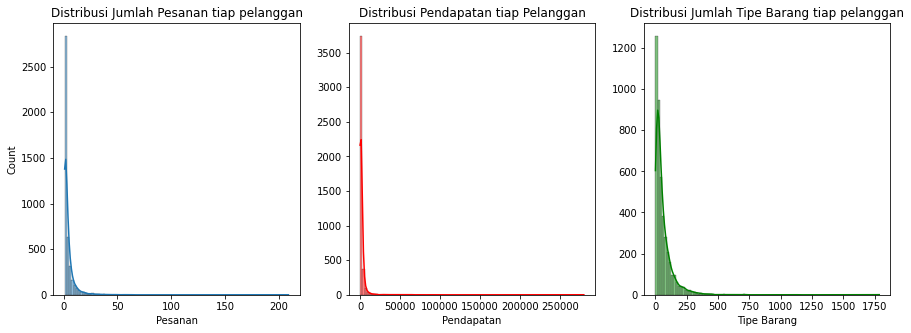

In [25]:
# plot Num_of_Order
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.histplot(df_customer['Num_of_Order'],bins=100,kde=True)
plt.title('Distribusi Jumlah Pesanan tiap pelanggan')
plt.xlabel('Pesanan')
plt.ylabel('Count')

# Plot Revenue
plt.subplot(1,3,2)
sns.histplot(df_customer['Revenue'],color='red',bins=100,kde=True)
plt.title('Distribusi Pendapatan tiap Pelanggan')
plt.xlabel('Pendapatan')
plt.ylabel('')

# Plot Num_of_Unique Product
plt.subplot(1,3,3)
sns.histplot(df_customer['Num_of_Unique_Product'],color='green',bins=100,kde=True)
plt.title('Distribusi Jumlah Tipe Barang tiap pelanggan')
plt.xlabel('Tipe Barang')
plt.ylabel('')
plt.show()

**Eksplorasi negara domisili pelanggan**

In [26]:
# dataframe berdasarkan negara
df_country = df.groupby('Country').agg({'TotalRevenue': lambda x: x.sum()}).sort_values('TotalRevenue',ascending=False)

# Persentase pendapatan berdasarkan negara
df_country['Perc_of_TotalRevenue'] = round(df_country.TotalRevenue/df_country.TotalRevenue.sum()*100,2)

# jumlah pelanggan
df_country['Customer_num'] = df.groupby('Country').CustomerID.nunique()

# Persentase pelanggan berdasarkan negara
df_country['Customer_rate'] = round(df_country.Customer_num/df_country.Customer_num.sum()*100,2)

df_country

,TotalRevenue,Perc_of_TotalRevenue,Customer_num,Customer_rate
Country,,,,
United Kingdom,7285024.644,81.97,3920,90.20
Netherlands,285446.340,3.21,9,0.21
EIRE,265262.460,2.98,3,0.07
Germany,228678.400,2.57,94,2.16
France,208934.310,2.35,87,2.00
Australia,138453.810,1.56,9,0.21
Spain,61558.560,0.69,30,0.69
Switzerland,56443.950,0.64,21,0.48
Belgium,41196.340,0.46,25,0.58


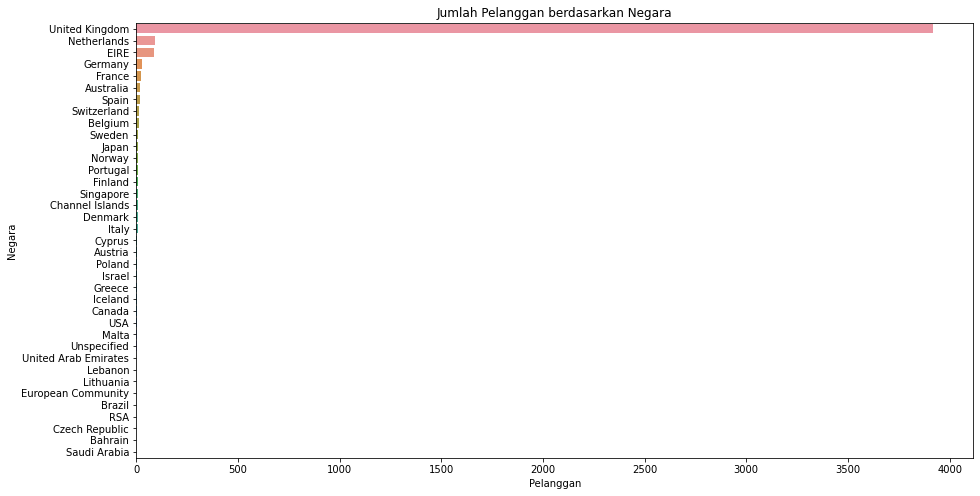

In [27]:
# plot pelanggan berdasarkan negara
plt.figure(figsize=(15,8))
sns.barplot(x=df_country.Customer_num.sort_values(ascending=False), y=df_country.index
           ).set_title("Jumlah Pelanggan berdasarkan Negara")
plt.xlabel("Pelanggan")
plt.ylabel("Negara");

Terlihat bahwa kebanyakan pelanggan berasal dari Britania Raya dengan persentase lebih dari 90%. Hal ini terbilang wajar karena perusahaan berdomisili di Inggris.

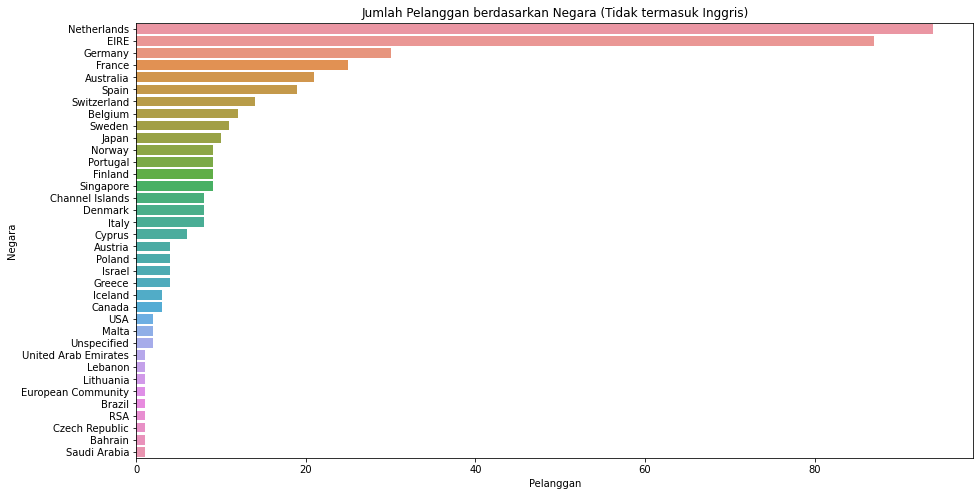

In [28]:
# plot asal negara tanpa Inggris
plt.figure(figsize=(15,8))
sns.barplot(y=df_country.iloc[1:].index, x=df_country.iloc[1:].Customer_num.sort_values(ascending=False)
           ).set_title("Jumlah Pelanggan berdasarkan Negara (Tidak termasuk Inggris)")
plt.xlabel("Pelanggan")
plt.ylabel("Negara");

Karena rentang antara Jumlah Pelanggan di Britania Raya dengan negara lain sangat jauh, dibuatlah grafik di atas yang tidak mengikutsertakan Britania Raya. Dari Grafik di atas terlihat bahwa kebanyakan Pelanggan berasal dari Benua Eropa. Dan produk yang dijual juga telah mencapai negara-negara di Asia dan Amerika Selatan.

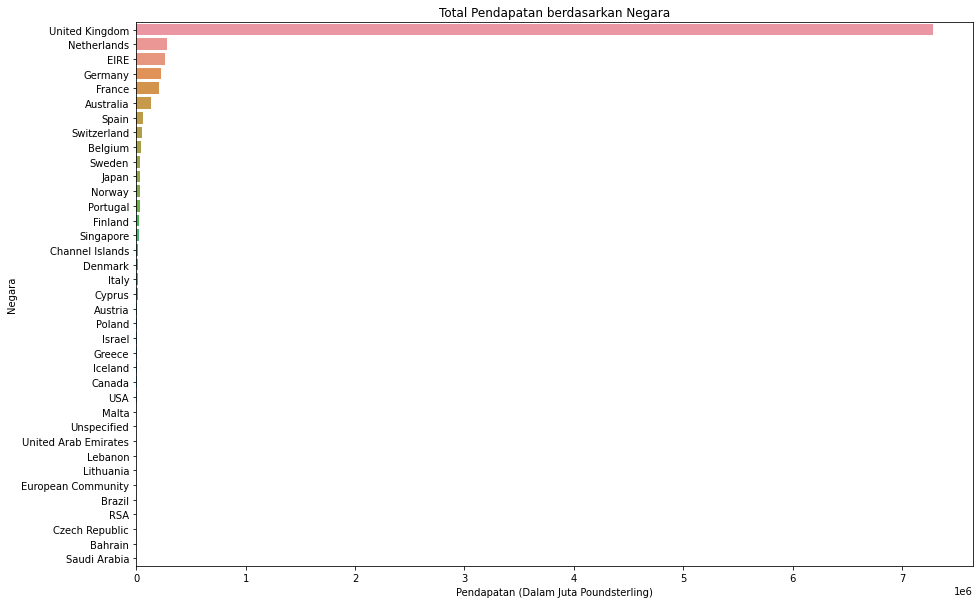

In [29]:
# plot pendapatan berdasarkan negara
plt.figure(figsize=(15,10))
sns.barplot(x=df_country.TotalRevenue.sort_values(ascending=False), y=df_country.index
           ).set_title('Total Pendapatan berdasarkan Negara')
plt.xlabel("Pendapatan (Dalam Juta Poundsterling)")
plt.ylabel("Negara");

Sejalan lurus dengan jumlah pelanggan. Jumlah Pendapatan juga paling banyak berasal dari Britania Raya.

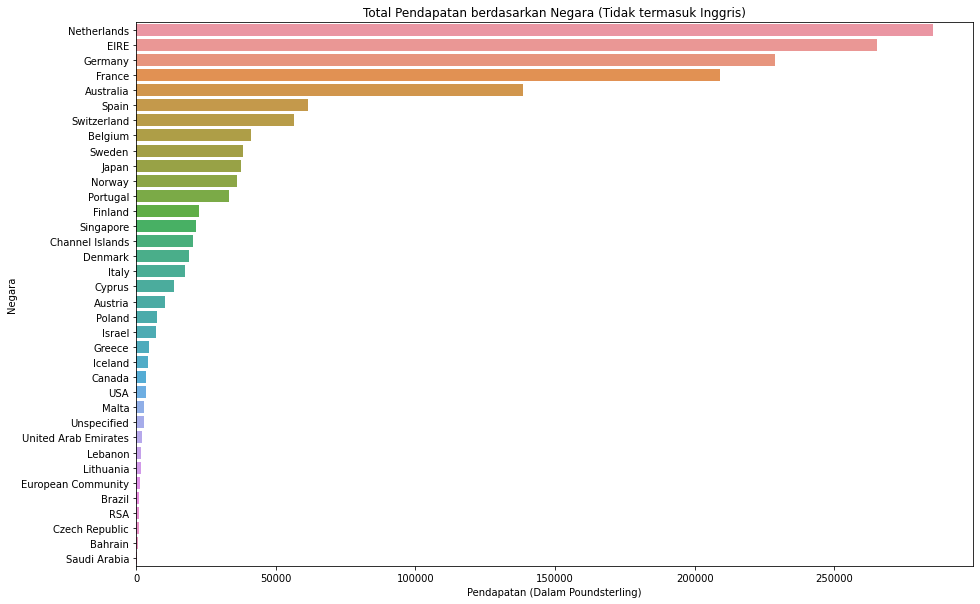

In [30]:
# plot pendapatan tanpa Inggris
plt.figure(figsize=(15,10))
sns.barplot(x=df_country.iloc[1:].TotalRevenue.sort_values(ascending=False),y=df_country.iloc[1:].index
           ).set_title('Total Pendapatan berdasarkan Negara (Tidak termasuk Inggris)')
plt.xlabel("Pendapatan (Dalam Poundsterling)")
plt.ylabel("Negara");

Tidak ditemukan perubahan signifikan antara grafik jumlah pelanggan dan pendapatan. Hal ini menunjukkan saat jumlah pelanggan naik maka pendapatan juga akan naik.

**Eksplorasi Britania Raya**

Britania Raya tidak hanya memiliki pendapatan penjualan terbanyak, tetapi juga pelanggan terbanyak. 
Karena sebagian besar kumpulan data ini berisi pesanan dari Britania Raya. Kita akan fokus untuk menjelajahi pasar Britania Raya dan menentukan segmentasi pasar pada pelanggan yang berdomisili di Britania Raya. 

In [31]:
# dataframe khusus Inggris
df_uk = df[df.Country=='United Kingdom']

In [32]:
# produk dengan penjualan terbanyak
uk_purchase = df_uk.groupby(['Description','UnitPrice'],as_index=False
             ).agg({'StockCode':'count'}
                  ).rename(columns={'StockCode':'Num_of_Purchase'}
                          ).sort_values(by='Num_of_Purchase',ascending=False).reset_index()

uk_purchase = uk_purchase.rename(columns={'index':'StockCode'})
uk_purchase.head(10)

,StockCode,Description,UnitPrice,Num_of_Purchase
0,8171,WHITE HANGING HEART T-LIGHT HOLDER,2.95,1572
1,421,ASSORTED COLOUR BIRD ORNAMENT,1.69,1273
2,6119,REGENCY CAKESTAND 3 TIER,12.75,1167
3,5228,PARTY BUNTING,4.95,1132
4,4248,LUNCH BAG RED RETROSPOT,1.65,1078
5,4228,LUNCH BAG BLACK SKULL.,1.65,995
6,3821,JUMBO BAG RED RETROSPOT,2.08,973
7,6629,SET OF 3 CAKE TINS PANTRY DESIGN,4.95,959
8,4759,NATURAL SLATE HEART CHALKBOARD,2.95,892
9,6236,REX CASH+CARRY JUMBO SHOPPER,0.95,888


Produk yang paling banyak terjual adalah hiasan. Sehingga untuk produk kategori ini dapat ditambah persediannya, terutama saat mendekati masa liburan yang membutuhkan ornamen.

In [33]:
# Produk yang jarang dibeli
uk_purchase[uk_purchase['Num_of_Purchase']==1]

,StockCode,Description,UnitPrice,Num_of_Purchase
6982,4360,MEDINA STAMPED METAL STOOL,34.95,1
6983,5339,PICNIC BASKET WICKER LARGE,3.00,1
6984,2824,FRENCH CHATEAU SMALL FRUITBOWL,2.55,1
6985,6461,SEASIDE FLYING DISC,1.06,1
6986,719,BLACK HEART CARD HOLDER,2.32,1
...,...,...,...,...
8531,5808,PURPLE CHUNKY GLASS+BEAD NECKLACE,11.95,1
8532,6768,SET OF 4 POLKADOT PLACEMATS,2.95,1
8533,1433,CHILDRENS CUTLERY SPACEBOY,3.75,1
8534,1435,CHILDRENS CUTLERY SPACEBOY,8.29,1


Ditemukan 1554 jenis produk yang hanya dibeli sekali. Untuk produk-produk ini dapat dievaluasi kembali apakah akan kembali dijual/tidak.

# 3. RFM analysis

Dalam analisa bisnis kali ini, akan digunakan konsep RFM untuk membagi pelanggan ke dalam segmen berbeda.

## Recency

Recency adalah waktu sejak pembelian terakhir yang dilakukan pelanggan.

In [34]:
# mengubah tipe data kolom InvoiceDate menjadi datetime
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

In [35]:
# Memilih tanggal acuan untuk menentukan waktu pembelian terakhir.
ref_date = max(df_uk['InvoiceDate'])
ref_date

Timestamp('2011-12-10 17:19:00')

In [36]:
# membuat kolom 'Date' berisi tanggal faktur tanpa menyertakan jam dan menit
df_uk['Date']= df_uk['InvoiceDate'].apply(lambda x: x.date())

# membuat kolom 'Last_Purchase_Date' yang berisi tanggal transaksi terakhir yang dilakukan pelanggan.
df_uk['Last_Purchase_Date']=df_uk.groupby(['CustomerID']).Date.transform(max)

# Menghitung Recency
df_uk['Recency']=df_uk.groupby('CustomerID')['Last_Purchase_Date'].apply(lambda x:ref_date.date() - x)
df_uk['Recency']=df_uk.agg({'Recency':lambda x:x.astype('timedelta64[D]')})

df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,Date,Last_Purchase_Date,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-01-12,2010-02-12,666.0
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12,666.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-01-12,2010-02-12,666.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12,666.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12,666.0


In [37]:
# Menghapus kolom 'Last_Purchase_Date' karena sudah tidak akan digunakan
df_uk = df_uk.drop('Last_Purchase_Date',axis=1)

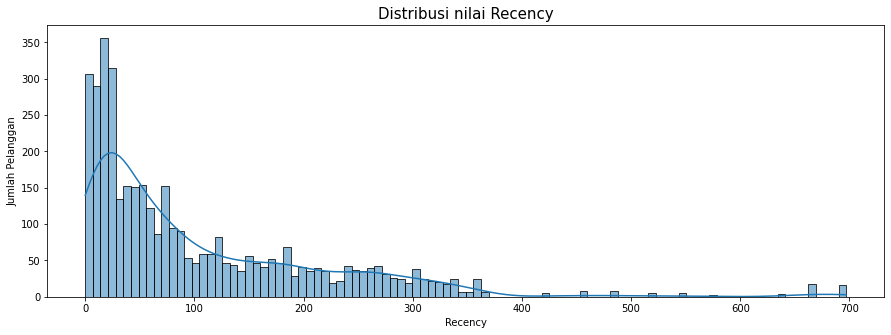

In [46]:
# Plot Recency distributions
plt.subplots(figsize=(15, 5))
sns.histplot(df_rfm['Recency'],bins=100,kde=True)
plt.title('Distribusi nilai Recency', fontsize = 15)
plt.xlabel('Recency')
plt.ylabel('Jumlah Pelanggan');

Terlihat bahwa distribusi nilai recency condong ke kanan. Hal ini menunjukkan bahwa kebanyakan pelanggan masih membeli produk yang dijual. Semakin besar nilai recency berarti semakin lama pelanggan tidak berbelanja.

## Frequency

Jumlah pembelian yang dilakukan pelanggan

In [41]:
# Menghitung Jumlah Pembelian yang dilakukan tiap Pelanggan
df_uk['Frequency'] = df_uk.groupby('CustomerID').InvoiceNo.transform('nunique')

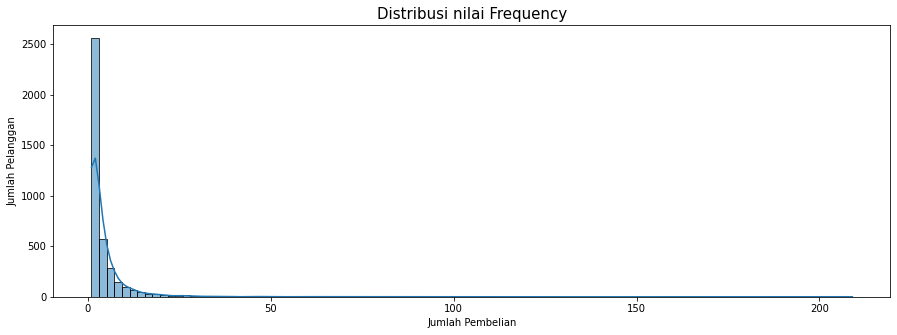

In [47]:
# Plot Frequency distributions
plt.figure(figsize=(15, 5))
sns.histplot(df_rfm['Frequency'],bins=100,kde=True)
plt.title('Distribusi nilai Frequency', fontsize = 15)
plt.xlabel('Jumlah Pembelian')
plt.ylabel('Jumlah Pelanggan');

Distribusi nilai Frequency sangat condong ke kanan. Hal ini menunjukkan bahwa Sebagian besar pelanggan melakukan sedikit pembelian. 

## Monetary
Jumlah uang yang dikeluarkan pelanggan

In [42]:
# Menghitung total pengeluaran"
df_uk['Monetary'] = df_uk.groupby('CustomerID').TotalRevenue.transform('sum')

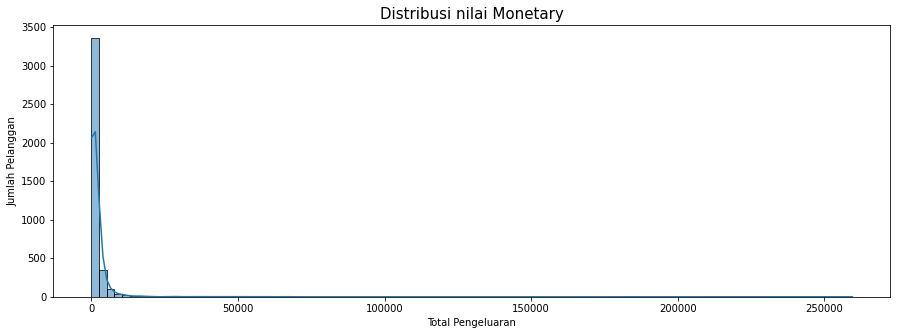

In [44]:
# Plot Monetary distributions
plt.subplots(figsize=(15, 5))
sns.histplot(df_rfm['Monetary'],bins=100,kde=True)
plt.title('Distribusi nilai Monetary', fontsize = 15)
plt.xlabel('Total Pengeluaran')
plt.ylabel('Jumlah Pelanggan');

Distribusi nilai Monetary sangat condong ke kanan. Hal ini menunjukkan bahwa Sebagian besar pelanggan mengeluarkan sedikit uangnya untuk membeli produk perusahaan. 

## Create RFM Table

In [43]:
# menggabungkan nilai recency, frequency dan monetary ke dalam satu dataframe
df_rfm = df_uk[['CustomerID','Recency','Frequency','Monetary']].drop_duplicates().reset_index(drop=True)
df_rfm.sort_index()

,CustomerID,Recency,Frequency,Monetary
0,17850.0,666.0,34,5391.21
1,13047.0,57.0,10,3237.54
2,13748.0,159.0,5,948.25
3,15100.0,70.0,3,876.00
4,15291.0,4.0,15,4668.30
...,...,...,...,...
3915,15471.0,151.0,1,454.48
3916,13436.0,120.0,1,196.89
3917,15520.0,120.0,1,343.50
3918,13298.0,120.0,1,360.00


# 4. Customer segmentation with RFM

Nilai RFM akan dibuat berdasarkan skala 5. Kemudian segmentasi pelanggan akan diukur berdasarkan nilai RFM.

In [48]:
# ranking pelanggan
df_rfm['R_rank'] = df_rfm['Recency'].rank(ascending=False)
df_rfm['F_rank'] = df_rfm['Frequency'].rank(ascending=True)
df_rfm['M_rank'] = df_rfm['Monetary'].rank(ascending=True)
 
# ranking yang dinormalisasi
df_rfm['R_rank_norm'] = (df_rfm['R_rank']/df_rfm['R_rank'].max())*100
df_rfm['F_rank_norm'] = (df_rfm['F_rank']/df_rfm['F_rank'].max())*100
df_rfm['M_rank_norm'] = (df_rfm['F_rank']/df_rfm['M_rank'].max())*100
 
# menghapus kolom yang tidak dipakai    
df_rfm.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,17850.0,666.0,34,5391.21,0.642343,99.260204,99.260204
1,13047.0,57.0,10,3237.54,52.723535,91.543367,91.543367
2,13748.0,159.0,5,948.25,25.745118,77.079082,77.079082
3,15100.0,70.0,3,876.00,47.571942,59.413265,59.413265
4,15291.0,4.0,15,4668.30,95.786228,95.918367,95.918367


In [49]:
# pembobotan dengan rumus 0.15*Recency score + 0.28*Frequency score + 0.57 *Monetary score
df_rfm['RFM_Score'] = 0.15*df_rfm['R_rank_norm']+0.28 *df_rfm['F_rank_norm']+0.57*df_rfm['M_rank_norm']

# mengubah nilai menjadi rentang 0-5
df_rfm['RFM_Score'] *= 0.05
df_rfm = df_rfm.round(2)

df_rfm[['CustomerID', 'RFM_Score']].head()

,CustomerID,RFM_Score
0,17850.0,4.22
1,13047.0,4.29
2,13748.0,3.47
3,15100.0,2.88
4,15291.0,4.79


Segmentasi Pelanggan berdasarkan nilai RFM

- RFM score >4.5 : Pelanggan terbaik
- 4.5 > RFM score > 4 : Pelanggan bernilai tinggi
- 4>RFM score >3 : Pelanggan bernilai sedang
- 3>RFM score>1.6 : Pelanggan bernilai rendah
- RFM score<1.6 : Pelanggan yang hilang

In [50]:
# membuat kolom segmentasi pelanggan
df_rfm["Customer_segment"] = np.where(df_rfm['RFM_Score'] > 4.5, "1. Top",
                                      (np.where(df_rfm['RFM_Score'] > 4, "2. High value",
                                                (np.where(df_rfm['RFM_Score'] > 3,"3. Medium Value",
                                                          np.where(df_rfm['RFM_Score'] > 1.6,'4. Low Value', '5. Lost'))))))

df_rfm[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)

,CustomerID,RFM_Score,Customer_segment
0,17850.0,4.22,2. High value
1,13047.0,4.29,2. High value
2,13748.0,3.47,3. Medium Value
3,15100.0,2.88,4. Low Value
4,15291.0,4.79,1. Top
5,14688.0,4.89,1. Top
6,17809.0,4.60,1. Top
7,15311.0,5.00,1. Top
8,16098.0,3.93,3. Medium Value
9,18074.0,0.73,5. Lost


In [51]:
# Deskripsi dari tiap segmentasi pelanggan
df_rfm.groupby('Customer_segment').agg({'Recency': ['mean','median','min','max'],
                                         'Frequency': ['mean','median','min','max'],
                                         'Monetary': ['mean','median','min','max','count']}).round(1)

Recency                    Frequency                  \
                    mean median  min    max      mean median min  max   
Customer_segment                                                        
1. Top              12.3   11.0  0.0   66.0      20.5   15.0   9  209   
2. High value       32.1   22.0  0.0  666.0       8.0    7.0   5   34   
3. Medium Value     53.5   30.0  0.0  314.0       4.3    4.0   3    9   
4. Low Value       110.5   86.0  0.0  697.0       2.3    2.0   2    3   
5. Lost            176.6  154.5  0.0  697.0       1.0    1.0   1    1   

                 Monetary                                  
                     mean  median     min       max count  
Customer_segment                                           
1. Top            11341.5  5447.0  1196.5  259657.3   297  
2. High value      2853.9  2364.2   201.1   26626.8   407  
3. Medium Value    1489.9  1218.3    36.6   10797.5   828  
4. Low Value        965.9   585.7     6.9  168472.5  1038  
5. Lost             384.3   244.6     3.8   77183.6  1350

In [52]:
# ringkasan hasil segmentasi pelanggan
avg_RFM_Points = df_rfm.groupby('Customer_segment').RFM_Score.mean().apply(lambda x:round(x,1))
number_of_customer = df_rfm['Customer_segment'].value_counts()
summary= pd.concat([avg_RFM_Points, number_of_customer], axis=1
                  ).rename(columns={"RFM_Score": "Avg_RFM_Points",
                                    "Customer_segment": "Num_of_Customers"})

summary

,Avg_RFM_Points,Num_of_Customers
1. Top,4.7,297
2. High value,4.2,407
3. Medium Value,3.5,828
4. Low Value,2.4,1038
5. Lost,1.0,1350


Pelanggan yang tergolong sebagai Top adalah pelanggan yang masih berbelanja produk perusahaan, banyak melakukan transaksi serta membelanjakan banyak uang. Semakin rendah urutan segmentasi semakin rendah pula nilai pelanggan bagi perusahaan.

## Plot RFM Segments

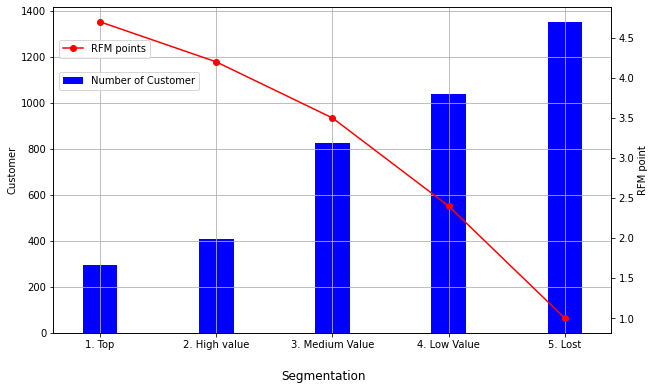

In [53]:
# Plot Segmentation
fig, ax = plt.subplots(figsize=(10,6))
summary['Num_of_Customers'].plot(ax=ax,color='b',label='Number of Customer',kind='bar',width=0.3,rot=0)
plt.legend(bbox_to_anchor=(0.01, 0.8), loc=2, borderaxespad=0.)
plt.ylabel('Customer')

# Plot RFM point
ax2 = ax.twinx()
summary['Avg_RFM_Points'].plot(ax=ax2,color='r',label='RFM points', marker='o')
plt.legend(bbox_to_anchor=(0.01, 0.9), loc=2, borderaxespad=0.)
plt.ylabel('RFM point')
fig.supxlabel("Segmentation")
ax.grid()

Grafik di atas menunjukkan jumlah pelanggan pada tiap segmentasi. Terlihat bahwa semakin tinggi nilai RFM, semakin rendah jumlah pelanggan.

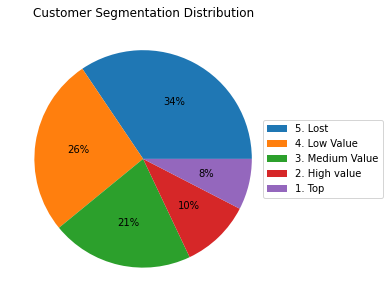

In [54]:
plt.figure(figsize=(7,5))
plt.pie(df_rfm.Customer_segment.value_counts(),
        autopct='%.0f%%')
plt.legend(df_rfm.Customer_segment.value_counts().index,loc='right',bbox_to_anchor=(1.4,0.5))
plt.title('Customer Segmentation Distribution')
plt.show()

Untuk meningkatkan penjualan, perusahaan dapat memberikan program khusus kepada segmentasi Top dan High Value. Hal ini karena pelanggan pada segmentasi ini memiliki kecendrungan tinggi untuk membeli produk dengan nominal yang besar. Selain itu pendekatan yang telah dipersempit ini akan memperkecil waktu dan biaya dibandingkan pemasaran yang dilakukan tanpa target pasar.

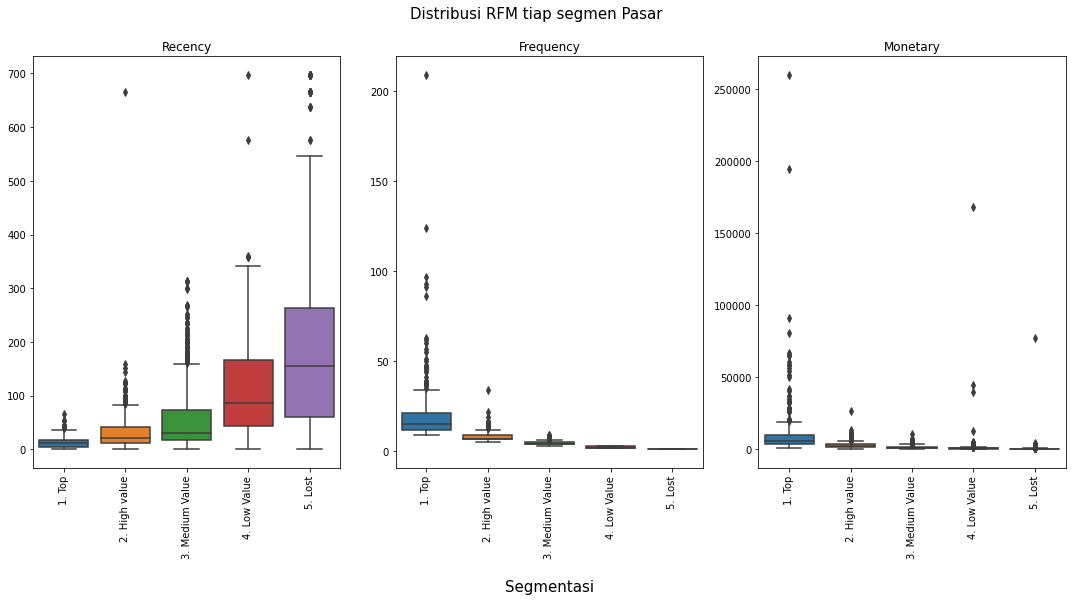

In [55]:
# plot distribusi RFM berdasarkan segmentasi
plt.figure(figsize=(15,8))

# plot recency tiap segmen
plt.subplot(1,3,1)
sns.boxplot(x=df_rfm['Customer_segment'].sort_values(ascending=True), y=df_rfm['Recency'])
plt.xticks(rotation=90)
plt.title('Recency')
plt.xlabel('')
plt.ylabel('')

# plot frequency tiap segmen
plt.subplot(1,3,2)
sns.boxplot(x=df_rfm['Customer_segment'].sort_values(ascending=True), y=df_rfm['Frequency'])
plt.xticks(rotation=90)
plt.title('Frequency')
plt.xlabel('\nSegmentasi',fontsize=15)
plt.ylabel('')

# plot monetary tiap segmen
plt.subplot(1,3,3)
sns.boxplot(x=df_rfm['Customer_segment'].sort_values(ascending=True), y=df_rfm['Monetary'])
plt.xticks(rotation=90)
plt.title('Monetary')
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.suptitle("Distribusi RFM tiap segmen Pasar",x=0.5,y=1.04, fontsize=15)
plt.show()

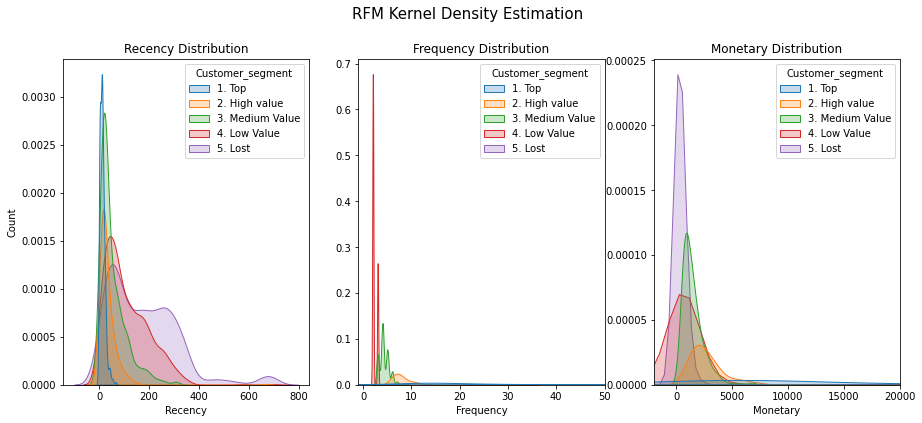

In [56]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
sns.kdeplot(data=df_rfm.sort_values(by="Customer_segment",ascending=True),x='Recency',hue="Customer_segment",shade=True)
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')


plt.subplot(1,3,2)
sns.kdeplot(data=df_rfm.sort_values(by="Customer_segment",ascending=True),x='Frequency',hue="Customer_segment",shade=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.xlim(-1, 50)
plt.ylabel('')


plt.subplot(1,3,3)
sns.kdeplot(data=df_rfm.sort_values(by="Customer_segment",ascending=True),x='Monetary',hue="Customer_segment",shade=True)
plt.title('Monetary Distribution')
plt.xlabel('Monetary')
plt.xlim(-2000, 20000)
plt.ylabel('')
plt.suptitle("RFM Kernel Density Estimation",x=0.5,y=1, fontsize=15)
plt.show()

Dari grafik Recency di atas, terlihat pelanggan pada segmentasi 1.Top baru-baru ini melakukan transaksi. Sedangkan pelanggan yang digolongkan 5.Lost sudah lama tidak melakukan transaksi.

Pada grafik Frequency, tidak tampak distribusi pelanggan yang dilabeli 5.Lost. Kemungkinan karena pelanggan pada segmen itu hanya berbelanja satu kali. Sedangkan pelanggan pada segmen 1.top memiliki frekuensi berbelanjanya sangat banyak, bahkan apabila dibandingkan dengan segmen nomor 2.High value.

Pada Grafik Monetary, segmentasi 5.Lost hanya membelanjakan sedikit uangnya. Sedangkan segmentasi 1. Top membelanjakan sangat banyak uang dibandingkan segmentasi lain.

# 5. Cohort analysis
Analisis Cohort secara khusus berguna dalam menganalisis pola pertumbuhan pengguna untuk produk sejak mereka pertama kali menggunakan produk, hingga tanggal terakhir dalam data.
Untuk e-commerce, analisis cohort adalah cara untuk mengetahui pelanggan mana yang paling berharga bagi bisnis mereka.

Karena analisis cohort berdasarkan catatan transaksi pelanggan, kolom yang akan digunakan yaitu:
- Invoice Data
- CustomerID
- Price
- Quantity

## customer cohort analysis

In [57]:
# Mengambil nilai tahun dan bulan dari kolom faktur. konversi ke format datetime 
def extract_ym(df):
    return df.apply(lambda x: x.strftime('%Y-%m')).astype('datetime64[ns]')

In [58]:
# mengambil nilai integer untuk tahun dan bulan dari kolom
def get_date_int(df, column):
    years = df[column].dt.year
    months = df[column].dt.month
    return years, months

In [59]:
# menggunakan fungsi extract_ym
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth']= extract_ym(df.InvoiceDate)

# tanggal transaksi pertama yang dilakukan tiap pelanggan
df['Cohort_date'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [60]:
# menggunakan fungsi get_date_inf
cohort_year, cohort_month = get_date_int(df, 'Cohort_date')
invoice_year, invoice_month = get_date_int(df, 'InvoiceDate')

In [61]:
# menggunakan variabel di atas untuk menghitung Cohort Index
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

df['CohortIndex'] = years_diff * 12 + months_diff

In [62]:
# Menghitung jumlah pelanggan berdasarkan Cohort Index
grouping_count = df.groupby(['Cohort_date', 'CohortIndex'])
cohort_data = grouping_count['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='Cohort_date',
                                  columns='CohortIndex',
                                  values='CustomerID')

In [63]:
# menampilkan tabel cohort
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(cohort_counts)

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Cohort_date,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,95.0,6.0,4.0,NaN,5.0,7.0,3.0,10.0,7.0,5.0,NaN,26.0,40.0,31.0,34.0,38.0,35.0,38.0,38.0,34.0,36.0,40.0,39.0,19.0
2010-02-01,93.0,NaN,NaN,NaN,2.0,6.0,3.0,7.0,4.0,NaN,25.0,30.0,29.0,30.0,33.0,32.0,31.0,37.0,27.0,33.0,37.0,43.0,15.0,NaN
2010-03-01,46.0,NaN,1.0,1.0,1.0,NaN,3.0,NaN,NaN,12.0,16.0,16.0,22.0,18.0,22.0,15.0,19.0,18.0,11.0,21.0,21.0,8.0,NaN,NaN
2010-05-01,69.0,2.0,3.0,1.0,4.0,1.0,NaN,25.0,34.0,21.0,35.0,30.0,31.0,34.0,31.0,33.0,32.0,34.0,41.0,20.0,NaN,NaN,NaN,NaN
2010-06-01,70.0,2.0,2.0,1.0,1.0,NaN,21.0,26.0,21.0,20.0,26.0,30.0,27.0,35.0,25.0,30.0,23.0,33.0,2.0,NaN,NaN,NaN,NaN,NaN
2010-07-01,50.0,NaN,1.0,1.0,NaN,6.0,20.0,22.0,19.0,18.0,24.0,18.0,21.0,18.0,20.0,17.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,83.0,NaN,1.0,NaN,20.0,34.0,26.0,34.0,29.0,33.0,30.0,33.0,32.0,34.0,37.0,44.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,67.0,NaN,NaN,15.0,27.0,17.0,24.0,22.0,27.0,19.0,25.0,20.0,20.0,25.0,27.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-01,40.0,NaN,9.0,13.0,13.0,16.0,17.0,9.0,11.0,12.0,9.0,14.0,13.0,17.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# Menghitung retention
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0).apply(lambda x: round(x,2))
retention.index = retention.index.strftime('%m-%Y')

In [65]:
# menampilkan tabel retention
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(retention.round(3) * 100)

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Cohort_date,,,,,,,,,,,,,,,,,,,,,,,,
01-2010,100.0,6.0,4.0,NaN,5.0,7.0,3.0,11.0,7.0,5.0,NaN,27.0,42.0,33.0,36.0,40.0,37.0,40.0,40.0,36.0,38.0,42.0,41.0,20.0
02-2010,100.0,NaN,NaN,NaN,2.0,6.0,3.0,8.0,4.0,NaN,27.0,32.0,31.0,32.0,35.0,34.0,33.0,40.0,29.0,35.0,40.0,46.0,16.0,NaN
03-2010,100.0,NaN,2.0,2.0,2.0,NaN,7.0,NaN,NaN,26.0,35.0,35.0,48.0,39.0,48.0,33.0,41.0,39.0,24.0,46.0,46.0,17.0,NaN,NaN
05-2010,100.0,3.0,4.0,1.0,6.0,1.0,NaN,36.0,49.0,30.0,51.0,43.0,45.0,49.0,45.0,48.0,46.0,49.0,59.0,29.0,NaN,NaN,NaN,NaN
06-2010,100.0,3.0,3.0,1.0,1.0,NaN,30.0,37.0,30.0,29.0,37.0,43.0,39.0,50.0,36.0,43.0,33.0,47.0,3.0,NaN,NaN,NaN,NaN,NaN
07-2010,100.0,NaN,2.0,2.0,NaN,12.0,40.0,44.0,38.0,36.0,48.0,36.0,42.0,36.0,40.0,34.0,54.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
08-2010,100.0,NaN,1.0,NaN,24.0,41.0,31.0,41.0,35.0,40.0,36.0,40.0,39.0,41.0,45.0,53.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09-2010,100.0,NaN,NaN,22.0,40.0,25.0,36.0,33.0,40.0,28.0,37.0,30.0,30.0,37.0,40.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10-2010,100.0,NaN,22.0,32.0,32.0,40.0,42.0,22.0,28.0,30.0,22.0,35.0,32.0,42.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualize

**Customer retention**

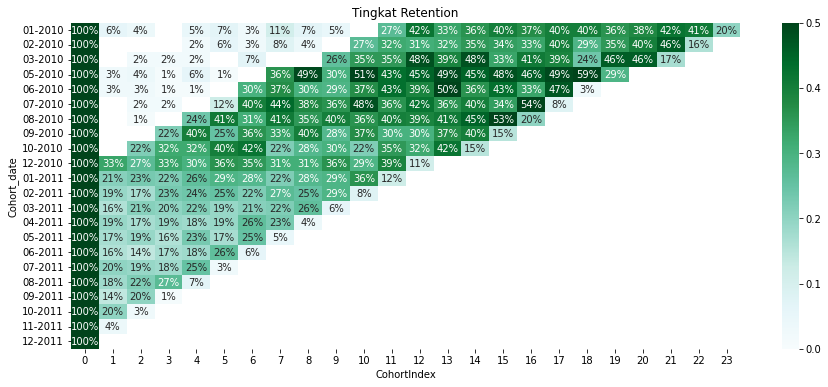

In [66]:
# plot tingkat retention
plt.figure(figsize=(15, 6))
plt.title('Tingkat Retention')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

kita dapat melihat dari grafik di atas bahwa banyak pengguna cenderung memperbanyak pembelian seiring berjalannya waktu.
Cohort 12-2010 adalah yang terkuat. Cohort 02-2011 dan 04-2011 adalah kohort terlemah.

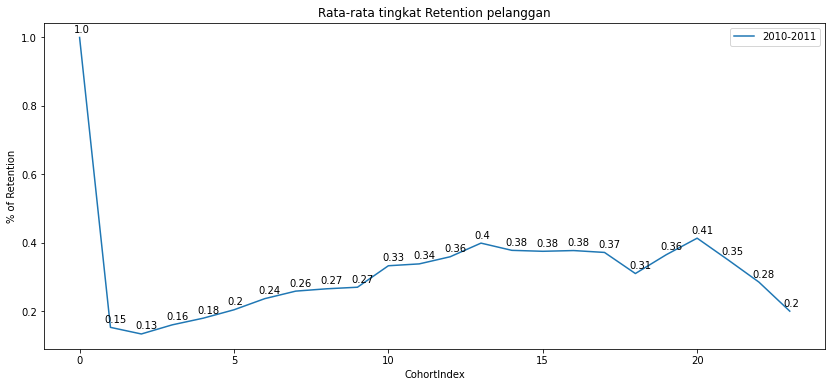

In [67]:
# plot tingkat retention
ax = retention.mean().plot(figsize=(14,6),label="2010-2011")
for i,v in enumerate(retention.mean()):
    ax.text(i-0.2,v+0.015,round(v,2))
plt.title('Rata-rata tingkat Retention pelanggan')
plt.ylabel('% of Retention')
plt.legend();

Terlihat bahwa pada masa-masa awal, terjadi penururan tajam untuk tingkat retention. Tetapi seiring berjalan waktu akan terjadi kenaikan tingkat retention.

Hal ini terbilang baik, karena berarti pada awalnya jumlah pelanggan menurun. Tetapi pelanggan yang ada masih tetap bertahan, dan diikuti dengan penambahan pelanggan baru. Sehingga menunjukkan pertumbuhan positif untuk jumlah pelanggan.

## Quantity Cohort Analysis

In [68]:
# membuat tabel cohort quantity
grouping_qty = df.groupby(['Cohort_date', 'CohortIndex'])
cohort_data_qty = grouping_qty['Quantity'].sum()
cohort_data_qty = cohort_data_qty.reset_index()
cohort_quantity = cohort_data_qty.pivot(index='Cohort_date',
                                     columns='CohortIndex',
                                     values='Quantity')
cohort_quantity.index = cohort_quantity.index.strftime('%m-%Y')

# membuat tabel retention berdasarkan quantity
cohort_quantity_sizes = cohort_quantity.iloc[:,0]
retention_quantity = cohort_quantity.divide(cohort_quantity_sizes, axis=0).apply(lambda x:round(x,2))

**Visualize**

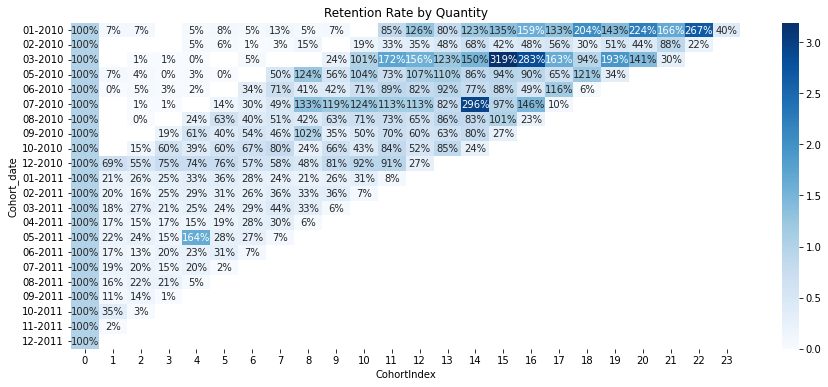

In [69]:
# tabel retention
plt.figure(figsize=(15, 6))
plt.title('Retention Rate by Quantity')
sns.heatmap(data = retention_quantity, fmt = '.0%', annot=True, cmap='Blues')
plt.show()

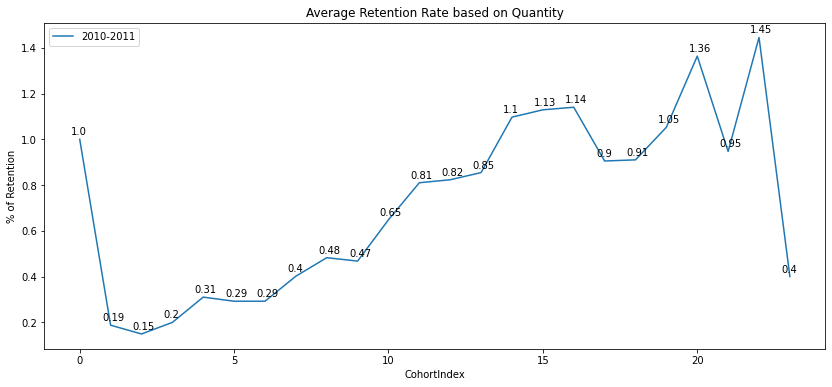

In [70]:
# plot tingkat retention berdasarkan quantity
ax = retention_quantity.mean().plot(figsize=(14,6),label="2010-2011")
for i,v in enumerate(retention_quantity.mean()):
    ax.text(i-0.28,v+0.02,round(v,2))
plt.title('Average Retention Rate based on Quantity')
plt.ylabel('% of Retention')
plt.legend();

Terjadi peningkatan tajam tingkat retention yang bahkan melewati nilai awal. Hal ini menunjukkan bahwa jumlah penjualan semakin banyak seiring berjalannya waktu.

Hal ini terbilang baik, karena menunjukkan pertumbuhan jumlah penjualan. Bahkan pada tanggal terakhir, tingkat retention lebih tinggi dibandingkan 8 bulan awal.

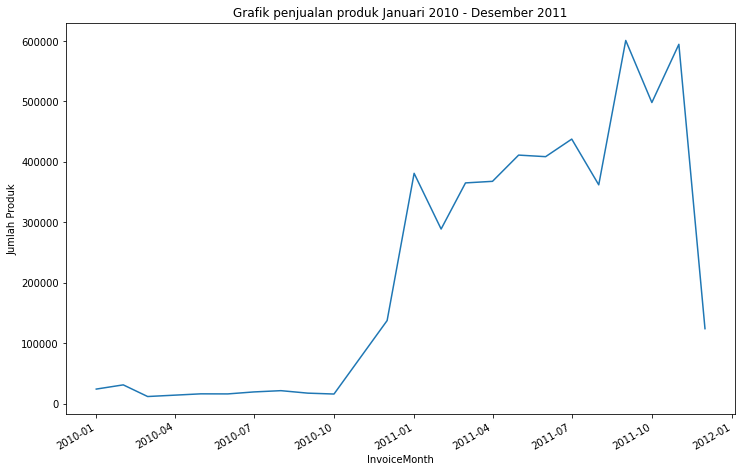

In [71]:
# total penjualan produk
df.groupby('InvoiceMonth')['Quantity'].sum().plot(figsize=(12,8))
plt.title('Grafik penjualan produk Januari 2010 - Desember 2011')
plt.ylabel('Jumlah Produk');

Tampak bahwa setelah Oktober 2010, terjadi peningkatan tajam jumlah penjualan. Hal ini senada dengan grafik tingkat retention. Jumlah penjualan meningkat pada akhir tahun dan menurun saat awal tahun, diprediksi bahwa banyak pelanggan memberi hadiah dan dekorasi untuk kebutuhan perayaan natal dan tahun baru.

## Revenue Cohort Analysis

In [72]:
# Menghitung tabel cohort revenue
grouping_revenue = df.groupby(['Cohort_date', 'CohortIndex'])
cohort_data_revenue = grouping_revenue['TotalRevenue'].sum()
cohort_data_revenue = cohort_data_revenue.reset_index()
cohort_revenue = cohort_data_revenue.pivot(index='Cohort_date',
                                     columns='CohortIndex',
                                     values='TotalRevenue')
cohort_revenue.index = cohort_revenue.index.strftime('%m-%Y')

# membuat tabel retention berdasarkan revenue
cohort_revenue_sizes = cohort_revenue.iloc[:,0]
retention_revenue = cohort_revenue.divide(cohort_revenue_sizes, axis=0).apply(lambda x:round(x,2))

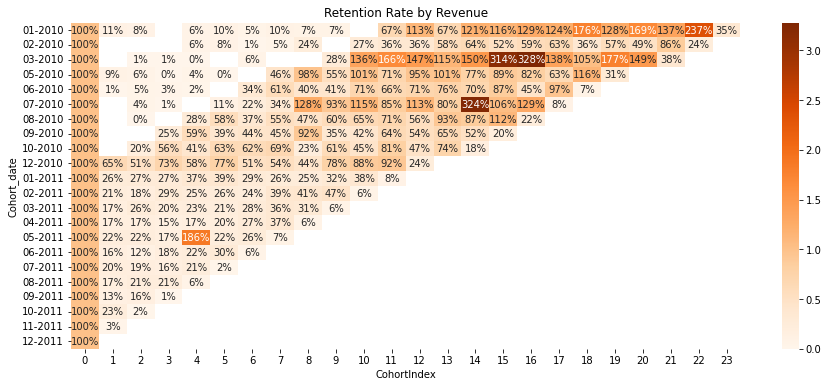

In [73]:
# Tabel retention
plt.figure(figsize=(15, 6))
plt.title('Retention Rate by Revenue')
sns.heatmap(data = retention_revenue, annot=True,fmt = '.0%',cmap='Oranges')
plt.show()

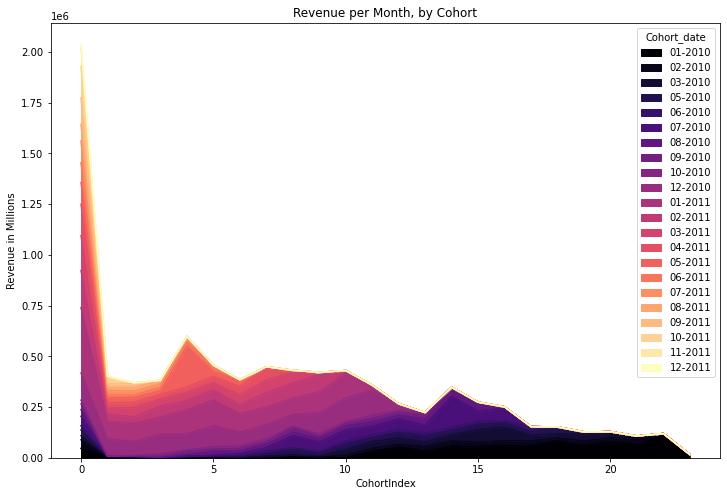

In [74]:
# plot total revenue berdasarkan awal transaksi
cohort_revenue.T.plot.area(figsize=(12,8),cmap='magma')
plt.title('Revenue per Month, by Cohort')
plt.ylabel('Revenue in Millions');

Melihat grafik area berwarna gelap, terlihat bahwa jumlah penjualan menurun sejak awal membeli (x=0) kemudian hampir mendekati angka 0, tetapi mulai naik sejak CohortIndex 10. Hal ini menunjukkan bahwa pelanggan yang sudah terdaftar sejak 01-2010, banyak yang kembali bertransaksi pada periode 10-2010 dan terus bertransaksi hingga saat ini.

Banyaknya total penjualan dari pelanggan yang terbilang baru terdaftar (warna jingga) menunjukkan bahwa banyak pelanggan baru yang puas dengan layanan dari perusahaan dan tetap memilih perusahaan ini untuk keperluan hadiah.

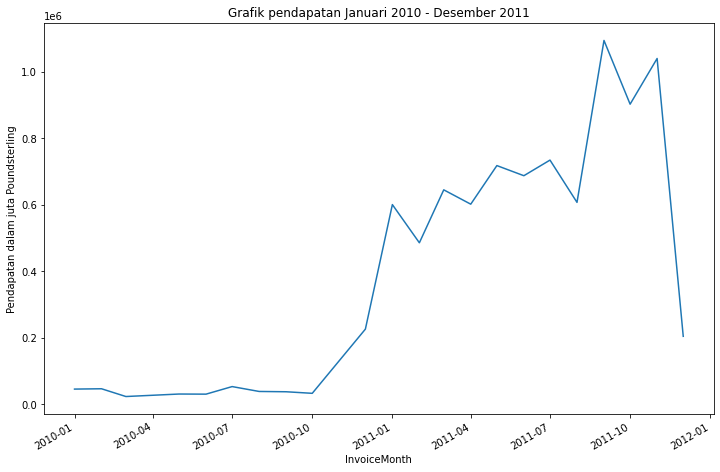

In [75]:
# total pendapatan
df.groupby('InvoiceMonth')['TotalRevenue'].sum().plot(figsize=(12,8))
plt.title('Grafik pendapatan Januari 2010 - Desember 2011')
plt.ylabel('Pendapatan dalam juta Poundsterling');

Senada dengan grafik jumlah penjualan, jumlah pendapatan juga meningkat saat akhir tahun 2010 dan mengalami penurunan saat awal tahun.